<a href="https://colab.research.google.com/github/Imenatrix/TCC-INFO19/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
%%capture
!sudo add-apt-repository -y ppa:openjdk-r/ppa
!sudo apt-get purge openjdk-*
!sudo apt-get install openjdk-8-jdk

In [2]:
%%capture
!pip3 install minerl

# Dependencies

In [3]:
import os
import time
import copy

from itertools import product
from collections import OrderedDict
from google.cloud import storage
from google.colab import drive

import minerl
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

from keras import Model
from keras.layers import *
from tensorflow import keras

/usr/local/lib/python3.7/dist-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

# Wrappers

In [5]:
wrappers = {}

def register_wrapper(name, wrapper):
    wrappers[name] = wrapper

## Amiranas

In [6]:
class ActionManager:
    """Main minecraft action wrapper. Simplifies action space to 130 discrete actions"""

    def __init__(self, c_action_magnitude=22.5):
        self.c_action_magnitude = c_action_magnitude

        self.zero_action = OrderedDict([('attack', 0),
                                        ('back', 0),
                                        ('camera', np.array([0., 0.])),
                                        ('forward', 0),
                                        ('jump', 0),
                                        ('left', 0),
                                        ('right', 0),
                                        ('sneak', 0),
                                        ('sprint', 0)])

        # camera discretization:
        self.camera_dict = OrderedDict([
            ('turn_up', np.array([-c_action_magnitude, 0.])),
            ('turn_down', np.array([c_action_magnitude, 0.])),
            ('turn_left', np.array([0., -c_action_magnitude])),
            ('turn_right', np.array([0., c_action_magnitude]))
        ])

        self.fully_connected_no_camera = ['attack', 'back', 'forward', 'jump', 'left', 'right', 'sprint']
        self.camera_actions = ['turn_up', 'turn_down', 'turn_left', 'turn_right']
        self.fully_connected = self.fully_connected_no_camera + self.camera_actions

        # following action combinations are excluded:
        self.exclude = [('forward', 'back'), ('left', 'right'), ('attack', 'jump'),
                        ('turn_up', 'turn_down', 'turn_left', 'turn_right')]

        # sprint only allowed when forward is used:
        self.only_if = [('sprint', 'forward')]

        # Maximal allowed mount of actions within one action:
        self.remove_size = 3

        # if more than 3 actions are present, actions are removed using this list until only 3 actions remain:
        self.remove_first_list = ['sprint', 'left', 'right', 'back',
                                  'turn_up', 'turn_down', 'turn_left', 'turn_right',
                                  'attack', 'jump', 'forward']

        self.fully_connected_list = list(product(range(2), repeat=len(self.fully_connected)))

        remove = []
        for el in self.fully_connected_list:
            for tuple_ in self.exclude:
                if sum([el[self.fully_connected.index(a)] for a in tuple_]) > 1:
                    if el not in remove:
                        remove.append(el)
            for a, b in self.only_if:
                if el[self.fully_connected.index(a)] == 1 and el[self.fully_connected.index(b)] == 0:
                    if el not in remove:
                        remove.append(el)
            if sum(el) > self.remove_size:
                if el not in remove:
                    remove.append(el)

        for r in remove:
            self.fully_connected_list.remove(r)

        self.action_list = []
        for el in self.fully_connected_list:
            new_action = copy.deepcopy(self.zero_action)
            for key, value in zip(self.fully_connected, el):
                if key in self.camera_actions:
                    if value:
                        new_action['camera'] = self.camera_dict[key]
                else:
                    new_action[key] = value
            self.action_list.append(new_action)

        self.num_action_ids_list = [len(self.action_list)]
        self.act_continuous_size = 0

    def get_action(self, id_):
        a = copy.deepcopy(self.action_list[int(id_)])
        a['camera'] += np.random.normal(0., 0.5, 2)
        return a

    def print_action(self, id_):
        a = copy.deepcopy(self.action_list[int(id_)])
        out = ""
        for k, v in a.items():
            if k != 'camera':
                if v != 0:
                    out += f'{k} '
            else:
                if (v != np.zeros(2)).any():
                    out += k

        print(out)

    def get_id(self, action, batch_size):

        coiso = np.zeros((batch_size,), dtype=int)
        action = copy.deepcopy(action)
        for i in range(batch_size):

            # discretize 'camera':
            camera = action['camera'][i]
            camera_action_amount = 0
            if - self.c_action_magnitude / 2. < camera[0] < self.c_action_magnitude / 2.:
                action['camera'][i][0] = 0.
                if - self.c_action_magnitude / 2. < camera[1] < self.c_action_magnitude / 2.:
                    action['camera'][i][1] = 0.
                else:
                    camera_action_amount = 1
                    action['camera'][i][1] = self.c_action_magnitude * np.sign(camera[1])
            else:
                camera_action_amount = 1
                action['camera'][i][0] = self.c_action_magnitude * np.sign(camera[0])

                action['camera'][i][1] = 0.

            # simplify action:
            for tuple_ in self.exclude:
                if len(tuple_) == 2:
                    a, b = tuple_
                    if action[a][i] and action[b][i]:
                        action[b][i] = 0
            for a, b in self.only_if:
                if not action[b][i]:
                    if action[a][i]:
                        action[a][i] = 0
            for a in self.remove_first_list:
                if sum([action[key][i] for key in self.fully_connected_no_camera]) > \
                        (self.remove_size - camera_action_amount):
                    if a in self.camera_actions:
                        action['camera'][i] = np.array([0., 0.])
                        camera_action_amount = 0
                    else:
                        action[a][i] = 0
                else:
                    break

            # set one_hot camera keys:
            for key in self.camera_actions:
                action[key] = [0 for x in range(batch_size)]
            for key, val in self.camera_dict.items():
                if (action['camera'][i] == val).all():
                    action[key][i] = 1
                    break

            non_separate_values = tuple(action[key][i] for key in self.fully_connected)

            coiso[i] = self.fully_connected_list.index(non_separate_values)
        return coiso

    def get_left_right_reversed_mapping(self):
        action_mapping = []
        for action in self.action_list:
            reversed_action = copy.deepcopy(action)
            if action['left'] == 1:
                reversed_action['left'] = 0
                reversed_action['right'] = 1
                assert action['right'] == 0
            if action['right'] == 1:
                reversed_action['right'] = 0
                reversed_action['left'] = 1
                assert action['left'] == 0
            if (action['camera'] == [0, -22.5]).all():
                reversed_action['camera'][1] = 22.5
            if (action['camera'] == [0, 22.5]).all():
                reversed_action['camera'][1] = -22.5

            rev_action_id = self.get_id(reversed_action)
            action_mapping.append(rev_action_id)

        return action_mapping

manager = ActionManager()
register_wrapper('amiranas', manager.get_id)

## Baseline Notebook

In [7]:
def dataset_action_batch_to_actions(dataset_actions, batch_size, camera_margin=3):
    """
    Turn a batch of actions from dataset (`batch_iter`) to a numpy
    array that corresponds to batch of actions of ActionShaping wrapper (_actions).

    Camera margin sets the threshold what is considered "moving camera".

    Note: Hardcoded to work for actions in ActionShaping._actions, with "intuitive"
        ordering of actions.
        If you change ActionShaping._actions, remember to change this!

    Array elements are integers corresponding to actions, or "-1"
    for actions that did not have any corresponding discrete match.
    """
    # There are dummy dimensions of shape one
    camera_actions = dataset_actions["camera"].squeeze()
    attack_actions = dataset_actions["attack"].squeeze()
    forward_actions = dataset_actions["forward"].squeeze()
    jump_actions = dataset_actions["jump"].squeeze()
    actions = np.zeros((batch_size,), dtype=int)

    for i in range(batch_size):
        # Moving camera is most important (horizontal first)
        if camera_actions[i][0] < -camera_margin:
            actions[i] = 4
        elif camera_actions[i][0] > camera_margin:
            actions[i] = 5
        elif camera_actions[i][1] > camera_margin:
            actions[i] = 6
        elif camera_actions[i][1] < -camera_margin:
            actions[i] = 7
        elif forward_actions[i] == 1:
            if jump_actions[i] == 1:
                actions[i] = 3
            else:
                actions[i] = 2
        elif attack_actions[i] == 1:
            actions[i] = 1
        else:
            # No reasonable mapping (would be no-op)
            actions[i] = 0
    return actions

register_wrapper('baseline_notebook', dataset_action_batch_to_actions)

# Data

In [8]:
%env MINERL_DATA_ROOT=/home/minerl
%env GOOGLE_APPLICATION_CREDENTIALS=/content/drive/MyDrive/key.json

env: MINERL_DATA_ROOT=/home/minerl
env: GOOGLE_APPLICATION_CREDENTIALS=/content/drive/MyDrive/key.json


In [9]:
!python3 -m minerl.data.download --environment "MineRLTreechop-v0"

/usr/local/lib/python3.7/dist-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'minerl.data.download' found in sys.modules after import of package 'minerl.data', but prior to execution of 'minerl.data.download'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-11-23 19:17:28 f8abff1e217a __main__[3717] INFO Downloading dataset for MineRLTreechop-v0 to /home/minerl
2022-11-23 19:17:28 f8abff1e217a __main__[3717] INFO Starting download ...
2022-11-23 19:17:28 f8abff1e217a root[3717] DEBUG Choosing mirror ...
2022-11-23 19:17:29 f8abff1e217a root[3717] DEBUG Picked https://minerl.s3.amazonaws.com/v4/MineRLTreechop-v0.tar ping=194.778ms
2022-11-23 19:17:29 f8abff1e217a root[3717] DEBUG Starting download at 0.0MB
2022-11-23 19:17:29 f8abff1e217a root[3717] DEBUG File size is 1510.7MB
Download: https://

In [10]:
def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    # The ID of your GCS bucket
    # bucket_name = "your-bucket-name"
    # The path to your file to upload
    # source_file_name = "local/path/to/file"
    # The ID of your GCS object
    # destination_blob_name = "storage-object-name"

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    
    blob.upload_from_filename(source_file_name)

    print(f"File {source_file_name} uploaded to {destination_blob_name}.")


In [11]:
def bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def int64_list_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

In [12]:
import minerl
import os
import time
from copy import deepcopy
import numpy as np
from minerl.data.util import multimap
import random

MINERL_DATA_ROOT = os.getenv('MINERL_DATA_ROOT')



def stack(*args):
    return np.stack(args)


class BufferedBatchIter:
    all_trajectories = None
    """
    A class that maintains and exposes an iterator which loads trajectories into a
    configurably-sized buffer, samples batches from that buffer, and refills the buffer
    when necessary.
    """
    def __init__(self,
                 data_pipeline,
                 buffer_target_size=50000):
        """
        Args:
            data_pipeline: A data pipeline object that you want to construct an iterator from
            buffer_target_size: How large you'd like your data buffer to be (in units of timesteps)

            Note that this is not an exact cap, since we don't know how large a trajectory will be
            until we load it in. This implementation tries to maintain a buffer size by keeping
            track of the average size of trajectories in this data pipeline, and loading a new
            trajectory when the size of the buffer is more than <average_size> below the target
        """
        self.data_pipeline = data_pipeline
        self.data_buffer = []
        self.buffer_target_size = buffer_target_size
        self.traj_sizes = []
        self.avg_traj_size = 0
        if BufferedBatchIter.all_trajectories == None:
            self.all_trajectories = self.data_pipeline.get_trajectory_names()
            BufferedBatchIter.all_trajectories = deepcopy(self.all_trajectories)
        else:
            self.all_trajectories = BufferedBatchIter.all_trajectories
        # available_trajectories is a dynamic, per-epoch list that will keep track of
        # which trajectories we haven't yet used in a given epoch
        self.available_trajectories = deepcopy(self.all_trajectories)
        #random.shuffle(self.available_trajectories)

    def optionally_fill_buffer(self):
        """
        This method is run after every batch, but only actually executes a buffer
        refill and re-shuffle if more data is needed
        """
        buffer_updated = False

        # Add trajectories to the buffer if the remaining space is
        # greater than our anticipated trajectory size (in the form of the empirical average)
        while (self.buffer_target_size - len(self.data_buffer)) > self.avg_traj_size:
            if len(self.available_trajectories) == 0:
                return
            traj_to_load = self.available_trajectories.pop()
            data_loader = self.data_pipeline.load_data(traj_to_load)
            traj_len = 0
            for data_tuple in data_loader:
                traj_len += 1
                self.data_buffer.append(data_tuple)

            self.traj_sizes.append(traj_len)
            self.avg_traj_size = np.mean(self.traj_sizes)
            buffer_updated = True
        #if buffer_updated:
            #random.shuffle(self.data_buffer)

    def get_batch(self, batch_size):
        """A simple utility method for constructing a return batch in the expected format"""
        ret_dict_list = []
        for _ in range(batch_size):
            data_tuple = self.data_buffer.pop()
            ret_dict = dict(obs=data_tuple[0],
                            act=data_tuple[1],
                            reward=data_tuple[2],
                            next_obs=data_tuple[3],
                            done=data_tuple[4])
            ret_dict_list.append(ret_dict)
        return multimap(stack, *ret_dict_list)

    def buffered_batch_iter(self, batch_size, num_epochs=None, num_batches=None):
        """
        The actual generator method that returns batches. You can specify either
        a desired number of batches, or a desired number of epochs, but not both,
        since they might conflict.

        ** You must specify one or the other **

        Args:
            batch_size: The number of transitions/timesteps to be returned in each batch
            num_epochs: Optional, how many full passes through all trajectories to return
            num_batches: Optional, how many batches to return

        """
        assert num_batches is not None or num_epochs is not None, "One of num_epochs or " \
                                                                  "num_batches must be non-None"
        assert num_batches is None or num_epochs is None, "You cannot specify both " \
                                                          "num_batches and num_epochs"

        epoch_count = 0
        batch_count = 0

        while True:
            # If we've hit the desired number of epochs
            if num_epochs is not None and epoch_count >= num_epochs:
                return
            # If we've hit the desired number of batches
            if num_batches is not None and batch_count >= num_batches:
                return
            # Refill the buffer if we need to
            # (doing this before getting batch so it'll run on the first iteration)
            self.optionally_fill_buffer()
            ret_batch = self.get_batch(batch_size=batch_size)
            batch_count += 1
            if len(self.data_buffer) < batch_size:
                assert len(self.available_trajectories) == 0, "You've reached the end of your " \
                                                              "data buffer while still having " \
                                                              "trajectories available; " \
                                                              "something seems to have gone wrong"
                epoch_count += 1
                self.available_trajectories = deepcopy(self.all_trajectories)
                #random.shuffle(self.available_trajectories)

            keys = ('obs', 'act', 'reward', 'next_obs', 'done')
            yield tuple([ret_batch[key] for key in keys])


In [13]:
def preprocess_expert_data(wrapper, examples_per_file, dataset_dir):
    wrap = wrappers[wrapper]

    data = minerl.data.make('MineRLTreechop-v0')
    iterator = BufferedBatchIter(data, 30000)

    try:
        os.makedirs(dataset_dir)
    except:
        pass

    i = 0

    state_buffer = []
    action_buffer = []
    reward_buffer = []
    state_next_buffer = []
    done_buffer = []

    gamma = 0.99

    filename = f'{i}.tfrecord'
    filepath = f'{dataset_dir}/{filename}'
    blobpath = f'tfrecords_nstep/{filename}'
    writer = tf.io.TFRecordWriter(filepath)

    examples = 0

    for state, action, reward, state_next, done in iterator.buffered_batch_iter(examples_per_file, num_epochs=1):
        state = state['pov'].squeeze().astype(np.float32) / 255
        state_next = state_next['pov'].squeeze().astype(np.float32) / 255
        action = wrap(action, examples_per_file).squeeze()

        for nstep_state, nstep_action, nstep_reward, nstep_state_next, nstep_done in zip(state, action, reward, state_next, done):
            state_buffer.append(nstep_state)
            action_buffer.append(nstep_action)
            reward_buffer.append(nstep_reward)
            state_next_buffer.append(nstep_state_next)
            done_buffer.append(nstep_done)

            if len(reward_buffer) == 10:

                nstep_reward_sum = 0
                episode_ended = nstep_done
                do_while = True

                while episode_ended or do_while:
                    for j in range(len(reward_buffer)):
                        nstep_reward_sum += gamma ** j * reward_buffer[j]

                    filename = f'{i}.tfrecord'
                    filepath = f'{dataset_dir}/{filename}'
                    blobpath = f'tfrecords_nstep/{filename}'

                    example = encode_example(
                        state_buffer[0],
                        action_buffer[0],
                        reward_buffer[0],
                        state_next_buffer[0],
                        done_buffer[0],
                        len(reward_buffer),
                        nstep_reward_sum,
                        nstep_state_next,
                        episode_ended
                    )
                    writer.write(example.SerializeToString())
                    examples += 1

                    if examples == examples_per_file:

                        writer.close()

                        upload_blob('minerl_data_records', filepath, blobpath)
                        os.remove(filepath)

                        examples = 0

                        i += 1

                        filename = f'{i}.tfrecord'
                        filepath = f'{dataset_dir}/{filename}'
                        blobpath = f'tfrecords_nstep/{filename}'
                        writer = tf.io.TFRecordWriter(filepath)

                    if done_buffer[0]:
                        episode_ended = False

                    state_buffer = state_buffer[1:]
                    action_buffer = action_buffer[1:]
                    reward_buffer = reward_buffer[1:]
                    state_next_buffer = state_next_buffer[1:]
                    done_buffer = done_buffer[1:]

                    do_while = False


In [14]:
def listdir(dir):
    return list(map(
        lambda file: dir + '/' + file,
        os.listdir(dir)
    ))

In [15]:
def create_dataset(filenames, batch_size):
    AUTOTUNE = tf.data.AUTOTUNE

    ignore_order = tf.data.Options()
    ignore_order.deterministic = False  # disable order, increase speed

    return (
        tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
            .with_options(ignore_order)
            .map(decode_example, num_parallel_calls=AUTOTUNE)
            .repeat()
            .batch(batch_size)
            .prefetch(AUTOTUNE)
    )

def create_val_dataset(filenames, batch_size):
    AUTOTUNE = tf.data.AUTOTUNE

    ignore_order = tf.data.Options()
    ignore_order.deterministic = False  # disable order, increase speed

    return (
        tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
            .with_options(ignore_order)
            .map(decode_example, num_parallel_calls=AUTOTUNE)
            .repeat()
            .batch(batch_size)
            .prefetch(AUTOTUNE)
    )

In [16]:
def encode_example(state, action, reward, state_next, done, nsteps, nstep_reward_sum, nstep_state_next, nstep_done):
  feature = {
      'state' : bytes_feature(tf.io.serialize_tensor(state)),
      'action' : int64_feature(action),
      'reward' : float_feature(reward),
      'state_next' : bytes_feature(tf.io.serialize_tensor(state_next)),
      'done' : int64_feature(done),
      'nsteps' : int64_feature(nsteps),
      'nstep_reward_sum' : float_feature(nstep_reward_sum),
      'nstep_state_next' : bytes_feature(tf.io.serialize_tensor(nstep_state_next)),
      'nstep_done' : int64_feature(nstep_done)
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))


def decode_example(example):
  feature_description = {
    'state': tf.io.FixedLenFeature([], tf.string),
    'action': tf.io.FixedLenFeature([], tf.int64),
    'reward' : tf.io.FixedLenFeature([], tf.float32),
    'state_next' : tf.io.FixedLenFeature([], tf.string),
    'done' : tf.io.FixedLenFeature([], tf.int64),
    'nsteps': tf.io.FixedLenFeature([], tf.int64),
    'nstep_reward_sum' : tf.io.FixedLenFeature([], tf.float32),
    'nstep_state_next' : tf.io.FixedLenFeature([], tf.string),
    'nstep_done' : tf.io.FixedLenFeature([], tf.int64)
  }
  example = tf.io.parse_single_example(example, feature_description)

  state = tf.io.parse_tensor(example['state'], out_type=tf.float32)
  state = tf.reshape(state, (64, 64, 3))

  state_next = tf.io.parse_tensor(example['state_next'], out_type=tf.float32)
  state_next = tf.reshape(state_next, (64, 64, 3))

  nstep_state_next = tf.io.parse_tensor(example['nstep_state_next'], out_type=tf.float32)
  nstep_state_next = tf.reshape(nstep_state_next, (64, 64, 3))

  return state, example['action'], example['reward'], state_next, example['done'], example['nsteps'], example['nstep_reward_sum'], nstep_state_next, example['nstep_done']

# Trainers

In [17]:
trainers = {}

def register_trainer(name, trainer):
    trainers[name] = trainer

## DQFD

In [18]:
from tqdm.notebook import tqdm
from collections import namedtuple

def dqfd(model, model_target, loss_fn, optimizer, dataset, val_dataset, steps, val_steps, epochs):
    dataset = iter(dataset)
    val_dataset = iter(val_dataset)

    def dqfd_metrics(inputs):

        (state, action, reward, state_next, done, nsteps, nstep_reward_sum, nstep_state_next, nstep_done) = inputs

        target_q_values = model_target(state)
        future_rewards = model_target(state_next)
        nstep_future_rewards = model_target(nstep_state_next)

        max_future_reward =  tf.reduce_max(future_rewards, axis=1)
        max_nstep_future_reward = tf.reduce_max(nstep_future_rewards, axis=1)

        updated_q_values = reward + gamma * max_future_reward
        updated_q_values = updated_q_values * tf.cast(1 - done, dtype=tf.float32) - tf.cast(done, dtype=tf.float32)

        updated_nstep_q_values = nstep_reward_sum + gamma ** tf.cast(nsteps, dtype=tf.float32) + max_nstep_future_reward
        updated_nstep_q_values = updated_nstep_q_values * tf.cast(1 - nstep_done, dtype=tf.float32) - tf.cast(done, dtype=tf.float32)

        masks = tf.one_hot(action, 112)

        return (target_q_values, updated_q_values, updated_nstep_q_values, masks)

    def val_step(state):
        (state, action, reward, state_next, done, nsteps, nstep_reward_sum, nstep_state_next, nstep_done) = inputs
        (target_q_values, updated_q_values, updated_nstep_q_values, masks) = dqfd_metrics(inputs)

        q_values = model(state)
        q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        lmc_loss = tf.reduce_mean(
            tf.reduce_max(
                tf.cast(
                    tf.equal(
                        masks,
                        0
                    ),
                    tf.float32
                ) + target_q_values,
                axis=1
            ) - tf.reduce_sum(masks * target_q_values, axis=1)
        )

        loss = loss_fn(updated_q_values, q_action) + loss_fn(updated_nstep_q_values, q_action) + lmc_loss + sum(model.losses)

        return loss

    def train_step(state):
        (state, action, reward, state_next, done, nsteps, nstep_reward_sum, nstep_state_next, nstep_done) = inputs
        (target_q_values, updated_q_values, updated_nstep_q_values, masks) = dqfd_metrics(inputs)

        with tf.GradientTape() as tape:
            q_values = model(state)
            q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)

            lmc_loss = tf.reduce_mean(
                tf.reduce_max(
                    tf.cast(
                        tf.equal(
                            masks,
                            0
                        ),
                        tf.float32
                    ) + target_q_values,
                    axis=1
                ) - tf.reduce_sum(masks * target_q_values, axis=1)
            )

            loss = loss_fn(updated_q_values, q_action) + loss_fn(updated_nstep_q_values, q_action) + lmc_loss + sum(model.losses)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss

    gamma = 0.99

    History = namedtuple('History', 'history')
    history = History(history={
        'loss': [],
        'val_loss': []
    })

    frame = 0

    for epoch in tqdm(range(epochs)):
        train_loss = 0
        val_loss = 0

        for _ in tqdm(tf.range(steps)):
            inputs = next(dataset)
            train_loss += train_step(inputs)

            frame += 1
            if frame % 1000 == 0:
                model_target.set_weights(model.get_weights())

        for _ in tf.range(val_steps):
            inputs = next(val_dataset)
            val_loss += val_step(inputs)

        history.history['loss'].append(train_loss / steps)
        history.history['val_loss'].append(val_loss / val_steps)
    
    return history

register_trainer('dqfd', dqfd)

## Optmized DQFD

In [19]:
from tqdm.notebook import tqdm
from collections import namedtuple

gamma = 0.99
frame = 0

def optimized_dqfd(model, model_target, loss_fn, optimizer, dataset, val_dataset, steps, val_steps, epochs, checkpoint_dir):
    dataset = strategy.experimental_distribute_dataset(dataset)
    val_dataset = strategy.experimental_distribute_dataset(val_dataset)

    dataset = iter(dataset)
    val_dataset = iter(val_dataset)

    def dqfd_metrics(inputs):

        (state, action, reward, state_next, done, nsteps, nstep_reward_sum, nstep_state_next, nstep_done) = inputs

        target_q_values = model_target(state)
        future_rewards = model_target(state_next)
        nstep_future_rewards = model_target(nstep_state_next)

        max_future_reward =  tf.reduce_max(future_rewards, axis=1)
        max_nstep_future_reward = tf.reduce_max(nstep_future_rewards, axis=1)

        updated_q_values = reward + gamma * max_future_reward
        updated_q_values = updated_q_values * tf.cast(1 - done, dtype=tf.float32) - tf.cast(done, dtype=tf.float32)

        updated_nstep_q_values = nstep_reward_sum + gamma ** tf.cast(nsteps, dtype=tf.float32) + max_nstep_future_reward
        updated_nstep_q_values = updated_nstep_q_values * tf.cast(1 - nstep_done, dtype=tf.float32) - tf.cast(done, dtype=tf.float32)

        masks = tf.one_hot(action, 112)

        return (target_q_values, updated_q_values, updated_nstep_q_values, masks)

    def train_step(inputs):

        (state, action, reward, state_next, done, nsteps, nstep_reward_sum, nstep_state_next, nstep_done) = inputs
        (target_q_values, updated_q_values, updated_nstep_q_values, masks) = dqfd_metrics(inputs)

        with tf.GradientTape() as tape:
            q_values = model(state)
            q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)

            lmc_loss = tf.reduce_sum(
                tf.reduce_max(
                    tf.cast(
                        tf.equal(
                            masks,
                            0
                        ),
                        tf.float32
                    ) + target_q_values,
                    axis=1
                ) - tf.reduce_sum(masks * target_q_values, axis=1)
            ) * (1. / BATCH_SIZE)
            
            q_loss = loss_fn(updated_q_values, q_action)
            nstep_loss = loss_fn(updated_nstep_q_values, q_action)
            l2_loss = tf.nn.scale_regularization_loss(model.losses)
            loss = q_loss + nstep_loss + lmc_loss + l2_loss

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        return loss

    def val_step(inputs):

        (state, action, reward, state_next, done, nsteps, nstep_reward_sum, nstep_state_next, nstep_done) = inputs
        (target_q_values, updated_q_values, updated_nstep_q_values, masks) = dqfd_metrics(inputs)

        q_values = model(state)
        q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)

        lmc_loss = tf.reduce_sum(
            tf.reduce_max(
                tf.cast(
                    tf.equal(
                        masks,
                        0
                    ),
                    tf.float32
                ) + target_q_values,
                axis=1
            ) - tf.reduce_sum(masks * target_q_values, axis=1)
        ) * (1. / BATCH_SIZE)
        
        q_loss = loss_fn(updated_q_values, q_action)
        nstep_loss = loss_fn(updated_nstep_q_values, q_action)
        l2_loss = tf.nn.scale_regularization_loss(model.losses)
        loss = q_loss + nstep_loss + lmc_loss + l2_loss

        return loss

    @tf.function
    def distributed_train_step(inputs):
        per_replica_losses = strategy.run(train_step, args=(inputs,))
        return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

    @tf.function
    def distributed_val_step(inputs):
        per_replica_losses = strategy.run(val_step, args=(inputs,))
        return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

    def train_epoch():
        global frame
        total_loss = 0

        for _ in tqdm(tf.range(steps)):
            inputs = next(dataset)
            # Train step
            total_loss += distributed_train_step(inputs)

            frame += 1
            if frame % 1000 == 0:
                model_target.set_weights(model.get_weights())

        return total_loss

    def validation():
        total_loss = 0
        for _ in tf.range(val_steps):
            inputs = next(val_dataset)
            # Val step
            total_loss += distributed_val_step(inputs)
        return total_loss

    History = namedtuple('History', 'history')
    history = History(history={
        'loss': [],
        'val_loss': []
    })

    for epoch in tqdm(range(epochs)):
        train_loss = train_epoch() / steps
        val_loss = validation() / val_steps

        history.history['loss'].append(train_loss)
        history.history['val_loss'].append(val_loss)

        if val_loss <= min(history.history['val_loss']):
            checkpoint_options = tf.train.CheckpointOptions(experimental_io_device='/job:localhost')
            model.save_weights(f'{checkpoint_dir}/{epoch:02d}-{val_loss:.2f}', options=checkpoint_options)

    return history

register_trainer('optimized_dqfd', optimized_dqfd)

## Behavioral Cloning

In [20]:
def behavioral_cloning(model, loss_fn, optimizer, dataset, val_dataset, steps, val_steps, epochs, checkpoint_dir):

    checkpoint_options = tf.train.CheckpointOptions(experimental_io_device='/job:localhost')
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir + '/{epoch:02d}-{val_loss:.2f}', save_weights_only=True, save_best_only=True, options=checkpoint_options)

    def format_for_classification(state, action, reward, state_next, done, nsteps, nstep_reward_sum, nstep_state_next, nstep_done):
        return state, action

    dataset = dataset.map(format_for_classification)
    val_dataset = val_dataset.map(format_for_classification)

    return model.fit(dataset, validation_data=val_dataset, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, epochs=epochs, callbacks=[model_checkpoint_callback])

register_trainer('behavioral_cloning', behavioral_cloning)

## DQN Epsilon Keras

In [21]:
def train(model, model_target, env):

    num_actions = 4

    seed = 42
    gamma = 0.99
    epsilon = 1.0
    epsilon_min = 0.1
    epsilon_max = 1.0
    epsilon_interval = (
        epsilon_max - epsilon_min
    )
    batch_size = 32
    max_steps_per_episode = 10000

    env.seed(seed)

    optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
    loss_function = keras.losses.Huber()

    action_history = []
    state_history = []
    state_next_history = []
    rewards_history = []
    done_history = []
    episode_reward_history = []

    frame_sample = []

    running_reward = 0
    episode_count = 0
    frame_count = 0

    epsilon_random_frames = 50000
    epsilon_greedy_frames = 10000000

    max_memory_length = 100000

    update_after_actions = 4
    update_target_network = 1000

    while True:
        state = np.array(env.reset())
        episode_reward = 0

        start = time.time()
        for timestep in range(1, max_steps_per_episode):

            end = time.time()
            frame_sample.append(end - start)
            if len(frame_sample) == 60 * 5:
                coiso = np.mean(frame_sample)
                print(f'FPS: {1 / coiso}')
                frame_sample = []
            start = time.time()

            #env.render()
            frame_count += 1

            if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
                action = np.random.choice(num_actions)
            else:
                state_tensor = tf.convert_to_tensor(state)
                state_tensor = tf.expand_dims(state_tensor, 0)
                action_probs = model(state_tensor, training=False)
                action = tf.argmax(action_probs[0]).numpy()
            
            epsilon -= epsilon_interval / epsilon_greedy_frames
            epsilon = max(epsilon, epsilon_min)

            state_next, reward, done, _ = env.step(action)
            state_next = np.array(state_next)

            episode_reward += reward

            action_history.append(action)
            state_history.append(state)
            state_next_history.append(state_next)
            done_history.append(done)
            rewards_history.append(reward)
            state = state_next

            if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
                
                indices = np.random.choice(range(len(done_history)), size=batch_size)

                state_sample = np.array([state_history[i] for i in indices])
                state_next_sample = np.array([state_next_history[i] for i in indices])
                rewards_sample = np.array([rewards_history[i] for i in indices])
                action_sample = np.array([action_history[i] for i in indices])
                done_sample = tf.convert_to_tensor(
                    [float(done_history[i]) for i in indices]
                )

                future_rewards = predict_target(model_target, state_next_sample)
                updated_q_values = rewards_sample + gamma * tf.reduce_max (
                    future_rewards, axis=1
                )
                updated_q_values = updated_q_values * (1 - done_sample) - done_sample

                masks = tf.one_hot(action_sample, num_actions)

                backpropagation(model, optimizer, loss_function, state_sample, updated_q_values, masks)

            if frame_count % update_target_network == 0:
                model_target.set_weights(model.get_weights())
                template = 'running reward: {:.2f} at episode {}, frame count {}'
                print(template.format(running_reward, episode_count, frame_count))

            if len(rewards_history) > max_memory_length:
                del rewards_history[:1]
                del state_history[:1]
                del state_next_history[:1]
                del action_history[:1]
                del done_history[:1]

            if done:
                break

            episode_reward_history.append(episode_reward)
            if len(episode_reward_history) > 100:
                del episode_reward_history[:1]
            running_reward = np.mean(episode_reward_history)

            episode_count += 1

            if running_reward > 40:
                print('Solved at episode {}!'.format(episode_count))
                break

@tf.function
def predict_target(model_target, state_next_sample):
    future_rewards = model_target(state_next_sample)
    return future_rewards

@tf.function
def backpropagation(model, optimizer, loss_function, state_sample, updated_q_values, masks):
    with tf.GradientTape() as tape:
        q_values = model(state_sample)
        q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        loss = loss_function(updated_q_values, q_action)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

# Models

In [22]:
models = {}

def register_model(name, model):
    models[name] = model

## Deepmind Atari

In [23]:
def deepmind_atari(input_shape, nb_outputs):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(32, 8, strides=4, activation='relu', kernel_regularizer='l2', bias_regularizer='l2')(inputs)
    x = Conv2D(64, 4, strides=4, activation='relu', kernel_regularizer='l2', bias_regularizer='l2')(x)
    x = Conv2D(64, 3, strides=1, activation='relu', kernel_regularizer='l2', bias_regularizer='l2')(x)

    x = Flatten()(x)

    x = Dense(512, activation='relu', kernel_regularizer='l2', bias_regularizer='l2')(x)
    output = Dense(nb_outputs, activation='linear', kernel_regularizer='l2', bias_regularizer='l2')(x)

    return Model(inputs=inputs, outputs=output)

register_model('deepmind_atari', deepmind_atari)

## Xception

In [24]:
def xception(input_shape, nb_outputs):
    inputs = Input(shape=input_shape)

    # Entry block
    x = Rescaling(1.0 / 255)(inputs)
    x = Conv2D(32, 3, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(64, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = Activation("relu")(x)
        x = SeparableConv2D(size, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = SeparableConv2D(size, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = SeparableConv2D(1024, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(nb_outputs, activation='linear')(x)
    return Model(inputs, outputs)

register_model('xception', xception)

# Main

In [ ]:
WRAPPER = 'amiranas'
MODEL = 'deepmind_atari'
TRAINER = 'behavioral_cloning'

EPOCHS = 30
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
EXAMPLES_PER_FILE = 2048

CHECKPOINT = '/content/drive/MyDrive/weights/checkpoint'
DATASET_DIR = '/home/minerl/tfrecords'

In [25]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
preprocess_expert_data(WRAPPER, EXAMPLES_PER_FILE, DATASET_DIR)

In [ ]:
gcs_pattern = 'gs://minerl_data_records/tfrecords_nstep/*.tfrecord'
filenames = tf.io.gfile.glob(gcs_pattern)
filenames = filenames[:10]
validation_split = 0.1
split = len(filenames) - int(len(filenames) * validation_split)
train_fns = filenames[:split]
validation_fns = filenames[split:]

dataset = create_dataset(train_fns, BATCH_SIZE)
val_dataset = create_val_dataset(validation_fns, BATCH_SIZE)

In [ ]:
with strategy.scope():
    model = models[MODEL]((64, 64, 3), 112)

    optimizer = tf.keras.optimizers.Adam()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    model.compile(optimizer, loss_fn, metrics=[val_acc_metric])

In [ ]:
model = models[MODEL]((64, 64, 3), 112)
model_target = models[MODEL]((64, 64, 3), 112)
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
loss_fn = keras.losses.Huber()

In [ ]:
with strategy.scope():
    model = models[MODEL]((64, 64, 3), 112)
    model_target = models[MODEL]((64, 64, 3), 112)
    optimizer = keras.optimizers.Adam(learning_rate=0.00001)
    loss_obj = keras.losses.Huber(reduction=tf.keras.losses.Reduction.NONE)

    def loss_fn(labels, predictions):
        per_example_loss = loss_obj(labels, predictions)
        return tf.reduce_sum(per_example_loss) * (1. / BATCH_SIZE)

In [ ]:
model.load_weights(CHECKPOINT)

In [ ]:
checkpoint_options = tf.train.CheckpointOptions(experimental_io_device='/job:localhost')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT, save_weights_only=True, save_best_only=True, options=checkpoint_options)

In [ ]:
steps_per_epoch = len(train_fns) * EXAMPLES_PER_FILE / BATCH_SIZE
validation_steps = len(validation_fns) * EXAMPLES_PER_FILE / BATCH_SIZE

history = trainers[TRAINER](model, loss_fn, optimizer, dataset, val_dataset, steps_per_epoch, validation_steps, EPOCHS, [model_checkpoint_callback])

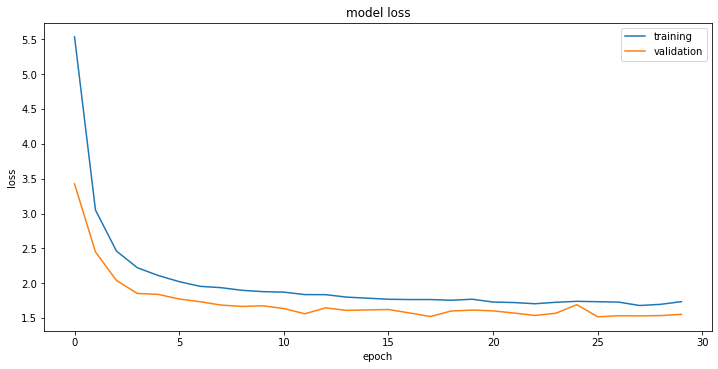

In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
#display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

# Experiment

## Setup

In [26]:
WRAPPER = 'amiranas'
MODEL = 'deepmind_atari'
TRAINER = 'behavioral_cloning'

EPOCHS = 30
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
EXAMPLES_PER_FILE = 2048

In [34]:
gcs_pattern = 'gs://minerl_data_records/tfrecords_nstep/*.tfrecord'
filenames = tf.io.gfile.glob(gcs_pattern)
validation_split = 0.1
split = len(filenames) - int(len(filenames) * validation_split)
train_fns = filenames[:split]
validation_fns = filenames[split:]

dataset = create_dataset(train_fns, BATCH_SIZE)
val_dataset = create_val_dataset(validation_fns, BATCH_SIZE)

steps_per_epoch = len(train_fns) * EXAMPLES_PER_FILE / BATCH_SIZE
validation_steps = len(validation_fns) * EXAMPLES_PER_FILE / BATCH_SIZE

In [33]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Behavioral Cloning

In [35]:
TRAINER = 'behavioral_cloning'
CHECKPOINT = '/content/drive/MyDrive/weights/behavioral_cloning_checkpoints'

In [36]:
with strategy.scope():
    model = models[MODEL]((64, 64, 3), 112)

    optimizer = tf.keras.optimizers.Adam()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    model.compile(optimizer, loss_fn, metrics=[val_acc_metric])

In [37]:
behavioral_cloning_history = trainers[TRAINER](model, loss_fn, optimizer, dataset, val_dataset, steps_per_epoch, validation_steps, EPOCHS, CHECKPOINT)

Epoch 1/30
788/788 [==============================] - 84s 100ms/step - loss: 2.2141 - sparse_categorical_accuracy: 0.5736 - val_loss: 1.9547 - val_sparse_categorical_accuracy: 0.5523
Epoch 2/30
788/788 [==============================] - 35s 44ms/step - loss: 1.7806 - sparse_categorical_accuracy: 0.5921 - val_loss: 1.8586 - val_sparse_categorical_accuracy: 0.5598
Epoch 3/30
788/788 [==============================] - 27s 35ms/step - loss: 1.7496 - sparse_categorical_accuracy: 0.6006 - val_loss: 1.8144 - val_sparse_categorical_accuracy: 0.5700
Epoch 4/30
788/788 [==============================] - 67s 86ms/step - loss: 1.7272 - sparse_categorical_accuracy: 0.6078 - val_loss: 1.8275 - val_sparse_categorical_accuracy: 0.5739
Epoch 5/30
788/788 [==============================] - 26s 33ms/step - loss: 1.7194 - sparse_categorical_accuracy: 0.6111 - val_loss: 1.8115 - val_sparse_categorical_accuracy: 0.5743
Epoch 6/30
788/788 [==============================] - 25s 32ms/step - loss: 1.7189 - spar

## DQfD

In [38]:
TRAINER = 'optimized_dqfd'
CHECKPOINT = '/content/drive/MyDrive/weights/dqfd_checkpoints'

In [39]:
with strategy.scope():
    model = models[MODEL]((64, 64, 3), 112)
    model_target = models[MODEL]((64, 64, 3), 112)
    optimizer = keras.optimizers.Adam(learning_rate=0.00001)
    loss_obj = keras.losses.Huber(reduction=tf.keras.losses.Reduction.NONE)

    def loss_fn(labels, predictions):
        per_example_loss = loss_obj(labels, predictions)
        return tf.reduce_sum(per_example_loss) * (1. / BATCH_SIZE)

In [40]:
dqfd_history = trainers[TRAINER](model, model_target, loss_fn, optimizer, dataset, val_dataset, steps_per_epoch, validation_steps, EPOCHS, CHECKPOINT)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

  0%|          | 0/788 [00:00<?, ?it/s]

## Results

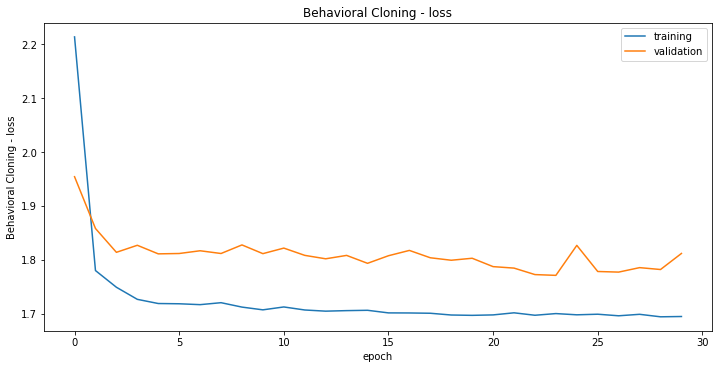

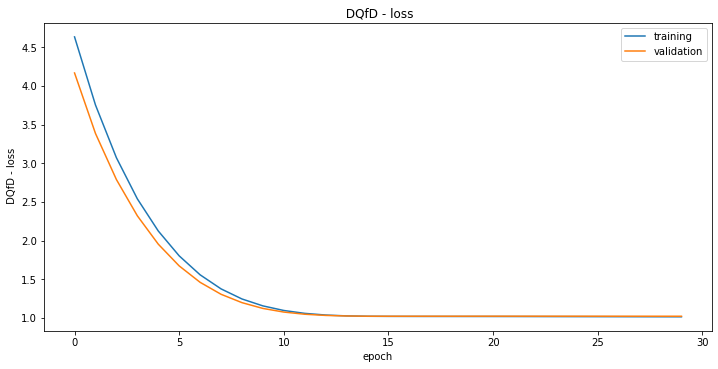

In [41]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title(title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()

display_training_curves(behavioral_cloning_history.history['loss'], behavioral_cloning_history.history['val_loss'], 'Behavioral Cloning - loss', 212)

plt.subplots(figsize=(10,10))
plt.tight_layout()

display_training_curves(dqfd_history.history['loss'], dqfd_history.history['val_loss'], ' DQfD - loss', 212)